In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
import sklearn
import HTMLParser
import re
from nltk.stem.porter import PorterStemmer as porterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords

C:\Users\shekh\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
stopwords_set = set(stopwords.words('english'));

In [3]:
def cleanText(inputText):
    tempText = inputText;
    tempText = re.sub('<[^<]+?>', ' ', tempText);
    tempText = re.sub(r'&amp[;]?', r' ', tempText);
    tempText = re.sub(r'\'s', ' ', tempText);
    tempText = re.sub(r'[\w\.-]+@[\w\.-]+', ' ', tempText);
    tempText = re.sub(r'[<>!#\[\]@/$:.,;%\()*?-]+', r' ', tempText);
    tempText = re.sub(r'\s+', r' ', tempText);
    words_filtered =[word.lower() for word in tempText.split()]
    cleanWordsList = [word for word in words_filtered if word not in stopwords_set]      #remove stopwords except few exceptions  
    cleanfeature = ' '.join(cleanWordsList)
    return cleanfeature

In [4]:
df = pd.read_json('C:/Users/shekh/Desktop/rentallisting/train.json')

In [5]:
df['display_address'] = df['display_address'].astype('category')
df['display_address_codes'] = df['display_address'].cat.codes

df['latitude'] = df['latitude'].astype('category')
df['latitude_codes'] = df['latitude'].cat.codes

df['longitude'] = df['longitude'].astype('category')
df['longitude_codes'] = df['longitude'].cat.codes

df['manager_id'] = df['manager_id'].astype('category')
df['manager_id_codes'] = df['manager_id'].cat.codes

df['interest_level'] = df['interest_level'].astype('category')
df['interest_level_codes'] = df['interest_level'].cat.codes

In [6]:
df['features'].head(10)

10                                                       []
10000     [Doorman, Elevator, Fitness Center, Cats Allow...
100004    [Laundry In Building, Dishwasher, Hardwood Flo...
100007                            [Hardwood Floors, No Fee]
100013                                            [Pre-War]
100014                                                   []
100016    [prewar, elevator, Dogs Allowed, Cats Allowed,...
100020    [Doorman, Elevator, Pre-War, Terrace, Laundry ...
100026    [Cats Allowed, Dogs Allowed, Elevator, Laundry...
100027                        [Dishwasher, Hardwood Floors]
Name: features, dtype: object

In [7]:
jointFeaturesDescDF = df[['description','features']];
label_column = df['interest_level_codes']
type(jointFeaturesDescDF)

pandas.core.frame.DataFrame

In [8]:
jointFeaturesDescList = []
for row in jointFeaturesDescDF.iterrows():
    tempList = row[1];
    description = tempList['description'];
    featureStr = ' '.join(tempList['features']);
    joinedStr = ' '.join([description,";",featureStr]);
    joinedStr = cleanText(joinedStr).encode('ascii', 'ignore').strip();
    jointFeaturesDescList.append(joinedStr);

In [9]:
print len(jointFeaturesDescList);

49352


In [10]:
jointFeaturesDescList[1]

'doorman elevator fitness center cats allowed dogs allowed'

In [11]:
label_column_list = label_column.tolist();

In [12]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df=0.00125,
                             max_df = 0.75,
                             sublinear_tf=True,
                             use_idf=True,
                             stop_words=u'english',
                             analyzer='word',
                             ngram_range=(1,3),lowercase=True)

In [13]:
totalVectors = vectorizer.fit_transform(jointFeaturesDescList);
print totalVectors.shape

(49352, 12780)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(totalVectors,label_column_list,test_size=0.25,random_state=15,stratify=label_column_list);

In [15]:
print X_train.shape
print X_test.shape

(37014, 12780)
(12338, 12780)


In [16]:
def generate_rf(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(n_estimators=50, min_samples_leaf=10,bootstrap=True,oob_score=True)
    rf.fit(X_train, y_train)
    print "rf score ", rf.score(X_test, y_test)
    return rf

def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a

In [17]:
rfs = [generate_rf(X_train, y_train, X_test, y_test) for i in xrange(10)]
rf_combined = reduce(combine_rfs, rfs)

print "rf combined score", rf_combined.score(X_test, y_test)

rf score  0.706759604474
rf score  0.707245906954
rf score  0.705057545793
rf score  0.707164856541
rf score  0.706354352407
rf score  0.707002755714
rf score  0.705624898687
rf score  0.706354352407
rf score  0.706597503647
rf score  0.706921705301
rf combined score 0.706597503647


In [18]:
predicted_labels = rf_combined.predict(X_test)

In [19]:
target_names = ['0', '1', '2']

In [20]:
actual_class_labels = y_test;
predicted_class_labels = predicted_labels.tolist();

In [21]:
print(classification_report(actual_class_labels, predicted_class_labels, target_names=target_names))

             precision    recall  f1-score   support

          0       0.64      0.03      0.05       960
          1       0.71      0.99      0.83      8571
          2       0.54      0.08      0.14      2807

avg / total       0.67      0.71      0.61     12338



In [22]:
df.columns

Index([            u'bathrooms',              u'bedrooms',
                 u'building_id',               u'created',
                 u'description',       u'display_address',
                    u'features',        u'interest_level',
                    u'latitude',            u'listing_id',
                   u'longitude',            u'manager_id',
                      u'photos',                 u'price',
              u'street_address', u'display_address_codes',
              u'latitude_codes',       u'longitude_codes',
            u'manager_id_codes',  u'interest_level_codes'],
      dtype='object')

In [23]:
featuresDF = df[['bathrooms','bedrooms','price','longitude_codes','latitude_codes','photos','display_address_codes','manager_id_codes']]

In [24]:
featuresDF.head(1)

,bathrooms,bedrooms,price,longitude_codes,latitude_codes,photos,display_address_codes,manager_id_codes
10,1.5,3,3000,879,867,[https://photos.renthop.com/2/7211212_1ed4542e...,6544,1239


In [25]:
new_features_df = pd.DataFrame();
type(new_features_df)
new_features_df.shape

(0, 0)

In [26]:
for row in featuresDF.iterrows():
    row[1].set_value('no_of_photos',len((row[1])['photos']));
    new_features_df = new_features_df.append(row[1]);

In [27]:
new_features_df = new_features_df.drop('photos', axis=1)
new_features_df['bathrooms'] = new_features_df['bathrooms'].astype('category')
new_features_df['bedrooms'] = new_features_df['bedrooms'].astype('category')
new_features_df['latitude_codes'] = new_features_df['latitude_codes'].astype('category')
new_features_df['longitude_codes'] = new_features_df['longitude_codes'].astype('category')
new_features_df['manager_id_codes'] = new_features_df['manager_id_codes'].astype('category')
new_features_df['no_of_photos'] = new_features_df['no_of_photos'].astype('category')
new_features_df['price'] = new_features_df['price'].astype('category')

In [28]:
new_features_df.head(1)

,bathrooms,bedrooms,display_address_codes,latitude_codes,longitude_codes,manager_id_codes,no_of_photos,price
10,1.5,3.0,6544.0,867.0,879.0,1239.0,5.0,3000.0


In [29]:
new_features_train, new_features_test, new_features_y_train, new_features_y_test = train_test_split(new_features_df,label_column_list,test_size=0.25,random_state=15,stratify=label_column_list)
print len(new_features_train)
print len(new_features_test)
print len(new_features_y_train)
print len(new_features_y_test)

37014
12338
37014
12338


In [30]:
def generate_rf(new_features_train, new_features_y_train, new_features_test, new_features_y_test):
    rf = RandomForestClassifier(n_estimators=50, min_samples_leaf=10,bootstrap=True,oob_score=True)
    rf.fit(new_features_train, new_features_y_train)
    print "rf score ", rf.score(new_features_test, new_features_y_test)
    return rf

def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a

In [31]:
rfs = [generate_rf(new_features_train, new_features_y_train, new_features_test, new_features_y_test) for i in xrange(10)]
rf_combined = reduce(combine_rfs, rfs)

print "rf combined score", rf_combined.score(new_features_test, new_features_y_test)

rf score  0.716728805317
rf score  0.71510779705
rf score  0.713729940023
rf score  0.715675149943
rf score  0.715269897876
rf score  0.715188847463
rf score  0.71559409953
rf score  0.71583725077
rf score  0.715026746636
rf score  0.71486464581
rf combined score 0.715756200357


In [32]:
predict_lab = rf_combined.predict(new_features_test)

In [33]:
new_features_actual_class_labels = new_features_y_test;
new_features_predicted_class_labels = predict_lab.tolist();

In [34]:
print(classification_report(new_features_actual_class_labels, new_features_predicted_class_labels, target_names=target_names))

             precision    recall  f1-score   support

          0       0.65      0.15      0.25       960
          1       0.74      0.96      0.84      8571
          2       0.44      0.16      0.24      2807

avg / total       0.67      0.72      0.66     12338



In [39]:
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [37]:
trace1 = go.Scatter(
    x=[1, 2, 3, 4, 5, 
       6, 7, 8, 9, 10],
    y=+[0.716728805317,0.71510779705,0.713729940023,0.715675149943,0.715269897876,0.715188847463,0.71559409953,0.71583725077,0.715026746636,0.71486464581],
    name = '<b>No</b> Gaps', # Style name/legend entry with html tags
    connectgaps=True
)
trace2 = go.Scatter(
    x=[1, 2, 3, 4, 5,
       6, 7, 8, 9, 10],
    y=[0.706759604474,0.707245906954,0.705057545793,0.707164856541,0.706354352407,0.707002755714,0.705624898687,0.706354352407,0.706597503647,0.706921705301],
    name = 'Gaps',
)

data = [trace1, trace2]



In [40]:
plt.plot([1, 2, 3, 4, 5, 
       6, 7, 8, 9, 10],[0.716728805317,0.71510779705,0.713729940023,0.715675149943,0.715269897876,0.715188847463,0.71559409953,0.71583725077,0.715026746636,0.71486464581])

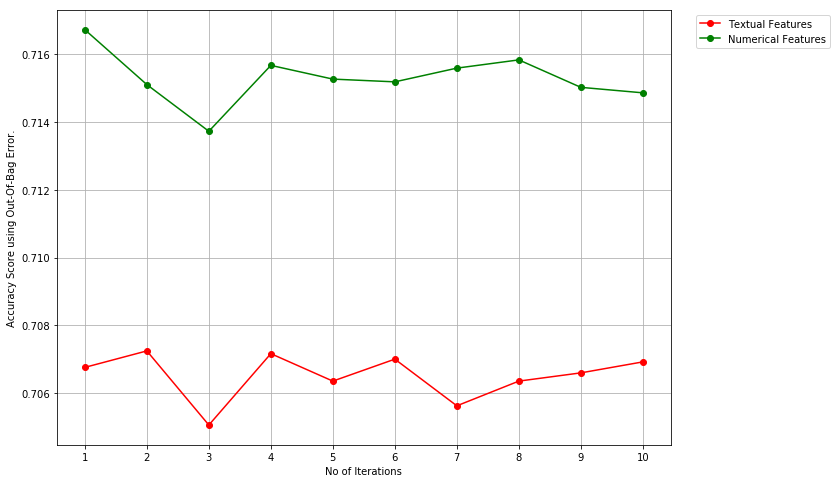

In [51]:
import matplotlib.pyplot as plt
import numpy as np

builds = np.array([1, 2, 3, 4,5,6,7,8,9,10])
y_stack = np.row_stack(([1, 2, 3, 4,5,6,7,8,9,10],[0.706759604474,0.707245906954,0.705057545793,0.707164856541,0.706354352407,0.707002755714,0.705624898687,0.706354352407,0.706597503647,0.706921705301],[0.716728805317,0.71510779705,0.713729940023,0.715675149943,0.715269897876,0.715188847463,0.71559409953,0.71583725077,0.715026746636,0.71486464581])) 

fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.plot(builds, y_stack[1,:], label='Textual Features', color='r', marker='o')
ax1.plot(builds, y_stack[2,:], label='Numerical Features', color='g', marker='o')
# ax1.plot(builds, y_stack[1,:], label='Component 2', color='g', marker='o')

plt.xticks(builds)
plt.xlabel('No of Iterations')
plt.ylabel('Accuracy Score using Out-Of-Bag Error.')

handles, labels = ax1.get_legend_handles_labels()
lgd = ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
ax1.grid('on')

plt.show()